In [31]:
import os
import requests
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from dotenv import load_dotenv
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

In [32]:
# Load API key from .env file
load_dotenv()
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')
if not GOOGLE_MAPS_API_KEY:
    raise ValueError("Google Maps API key not found. Please set it in the .env file.")

# List of places with GPS coordinates
places = [
    (28.7400646, -13.8693225, "Corralejo"),
    (28.6827004, -14.0101076, "El Cotillo"),
    (28.6802009, -13.9340479, "Lajares"),
    (28.7501766, -13.8217035, "Isla de Lobos")
]

In [33]:
# Check available fonts
available_fonts = sorted([f.name for f in fontManager.ttflist])
print("Available fonts: ", available_fonts)

# Set the font properties (use a different font if Nanum Gothic is not available)
font_properties_city = FontProperties(family='.aqua kana', size=30)  # Font for city name
font_properties_country = FontProperties(family='.aqua kana', size=20)  # Font for country name

Available fonts:  ['.Aqua Kana', '.Keyboard', '.New York', '.New York', '.SF Arabic', '.SF Arabic Rounded', '.SF Armenian', '.SF Armenian Rounded', '.SF Camera', '.SF Compact', '.SF Compact', '.SF Compact Rounded', '.SF Georgian', '.SF Georgian Rounded', '.SF Hebrew', '.SF Hebrew Rounded', '.SF NS Mono', '.SF NS Mono', '.SF NS Rounded', '.SF Soft Numeric', '.ThonburiUI', 'Abolition', 'Academy Engraved LET', 'Al Bayan', 'Al Nile', 'Al Tarikh', 'Alegreya', 'Alegreya', 'Alegreya', 'American Typewriter', 'Andale Mono', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Braille', 'Apple Chancery', 'Apple SD Gothic Neo', 'Apple Symbols', 'AppleGothic', 'AppleMyungjo', 'Arial', 'Arial', 'Arial', 'Arial', 'Arial Black', 'Arial Hebrew', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Narrow', 'Arial Rounded MT Bold', 'Arial Unicode MS', 'Arial Unicode MS', 'Athelas', 'Avenir', 'Avenir Next', 'Avenir Next Condensed', 'Ayuthaya', 'Baghdad', 'Bangla MN', 'Bangla Sang

In [34]:
from shapely.geometry import Point

# Assuming df_cleaned has 'lat' and 'lon' columns
df_cleaned['geometry'] = df_cleaned.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

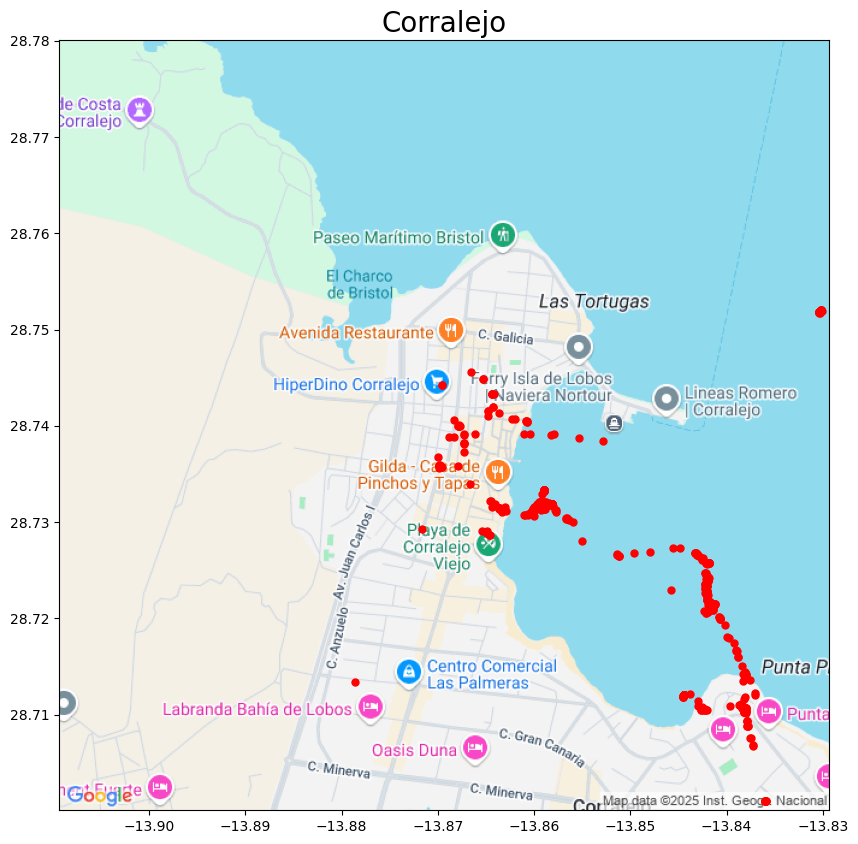

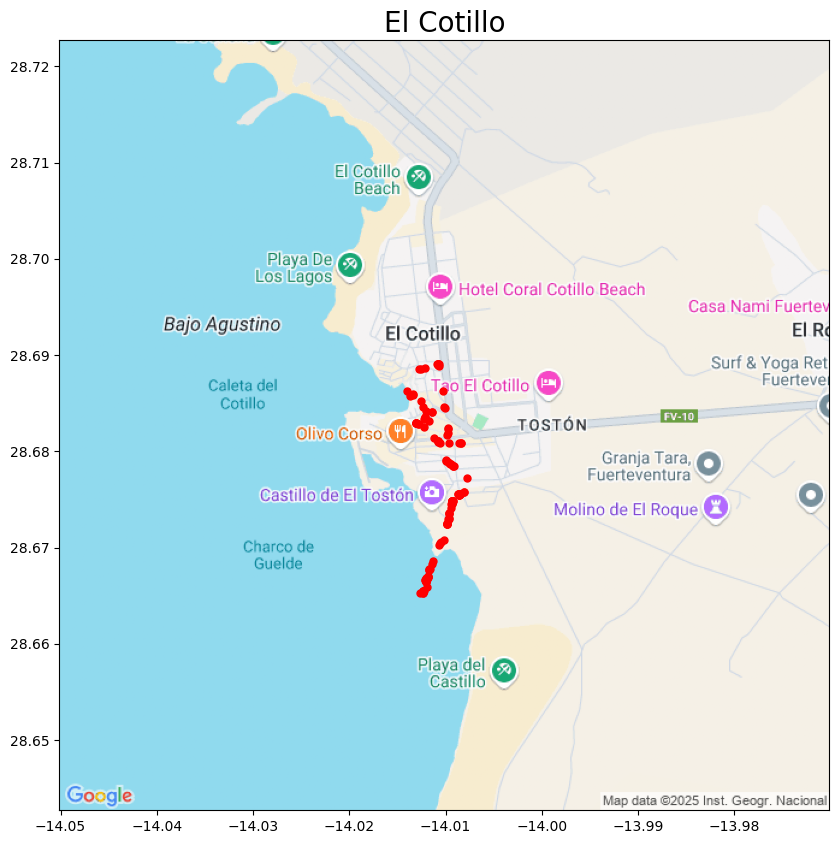

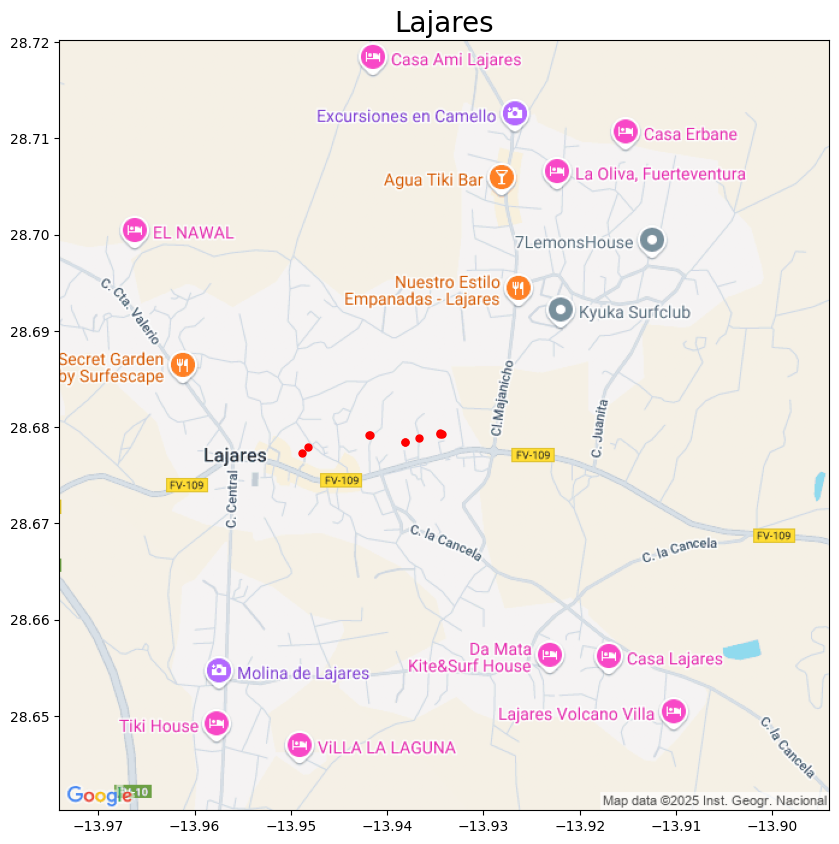

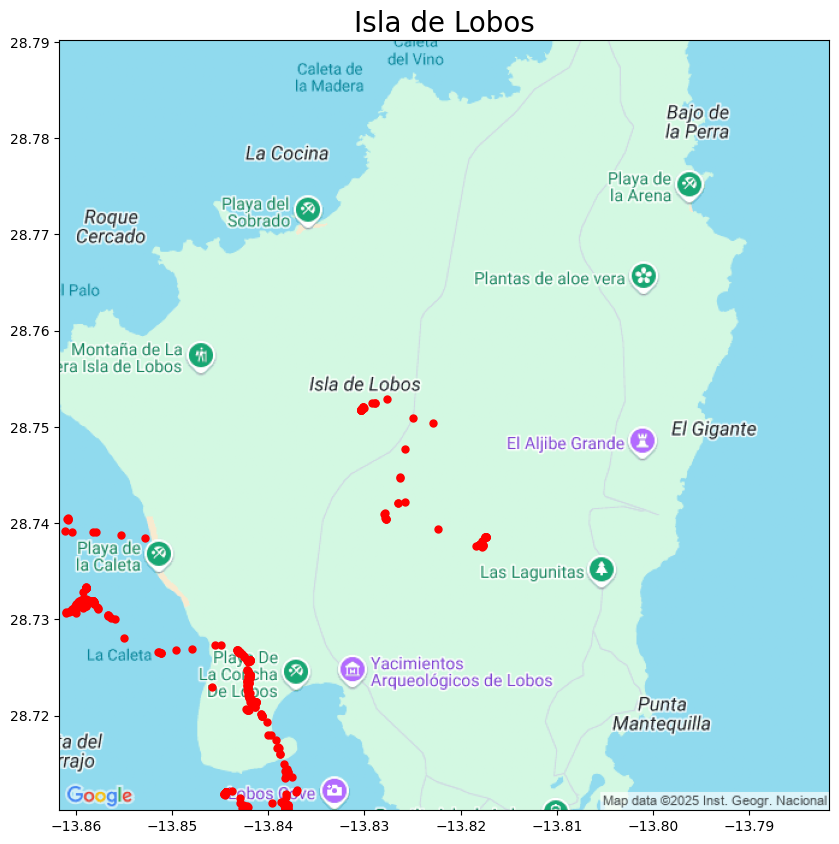

In [ ]:
for lat, lon, place_name in places:
    # Fetch the static map from Google Maps Static API
    map_url = (
        f"https://maps.googleapis.com/maps/api/staticmap?center={lat},{lon}"
        f"&zoom=15&size=800x800&maptype=roadmap&key={GOOGLE_MAPS_API_KEY}"
    )
    response = requests.get(map_url)
    if response.status_code != 200:
        print(f"Failed to fetch map for {place_name}. HTTP Status: {response.status_code}")
        continue

    # Save the map image
    map_filename = f"{place_name.replace(' ', '_')}_map.png"
    with open(map_filename, 'wb') as f:
        f.write(response.content)

    # Load GPS data from CSV
    csv_path = 'Fuerteventura2025_cleaned_info.csv'
    try:
        df = pd.read_csv(csv_path)
        df_cleaned = df.dropna(subset=['lat', 'lon'])
    except FileNotFoundError:
        print(f"CSV file not found: {csv_path}. Skipping GPS points.")
        continue

    # Filter GPS points within proximity of the center point
    proximity_threshold = 0.05  # Approx. 4km radius
    df_cleaned = df_cleaned[(df_cleaned['lat'] >= lat - proximity_threshold) &
                            (df_cleaned['lat'] <= lat + proximity_threshold) &
                            (df_cleaned['lon'] >= lon - proximity_threshold) &
                            (df_cleaned['lon'] <= lon + proximity_threshold)]

    # Plot the map and overlay GPS points
    img = plt.imread(map_filename)
    fig, ax = plt.subplots(figsize=(10, 10))

    # Adjust the extent to fill the 800x800 space
    extent = [lon - 0.05, lon + 0.05, lat - 0.05, lat + 0.05]
    ax.imshow(img, extent=extent)

    # Overlay GPS points
    for _, row in df_cleaned.iterrows():
        ax.plot(row['lon'], row['lat'], marker='o', color='red', markersize=5)

    # Add title and save the plot
    ax.set_title(place_name, fontsize=20)
    plt.savefig(f"{place_name.replace(' ', '_')}_overlay.png", dpi=300)
    plt.show()